## Requirements and Imports


In [1]:
import copy
import os
from pathlib import Path
from itertools import combinations
from scipy import stats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from torch.utils.data import TensorDataset, DataLoader , WeightedRandomSampler

from sklearn.metrics import roc_auc_score , pairwise_distances
import torch
import torch.optim as optim
epoch_num=50
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
import scipy.sparse as sp
from numba import jit
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader , WeightedRandomSampler
import torch.optim as optim



In [2]:
import matplotlib as mpl
sns.set_theme()
# plt.rcParams.update(plt.rcParamsDefault)

plt.rcParams.update({'font.size': 18,
                     'xtick.labelsize' : 18,
                     'ytick.labelsize' : 18})

mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['axes.facecolor'] = 'white'

In [3]:
device

device(type='cuda', index=0)

In [4]:
class Net(nn.Module):
    def __init__(self, input_size, output_size,activation='relu',hidden_layers=2):
        """
        Initializes a feedforward neural network with three fully-connected layers.

        Args:
            input_size (int): Size of the input layer.
            output_size (int): Size of the output layer.
        """
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, int(input_size / 2))
        self.fc2 = nn.Linear(int(input_size / 2), int(input_size / 4))
        self.fc3 = nn.Linear(int(input_size / 4), int(input_size / 4))
        self.fc4 = nn.Linear(int(input_size / 4), int(input_size / 4))
        self.fc5 = nn.Linear(int(input_size / 4), output_size)
        if activation == 'relu':
            self.activation = F.relu
        elif activation == 'tanh':
            self.activation = F.tanh
        elif activation == 'sigmoid':
            self.activation = F.sigmoid
        self.hidden_layers = hidden_layers

    def forward(self, x):
        """
        Performs the forward pass of the neural network.

        Args:
            x (torch.Tensor): Input data of shape (batch_size, input_size).

        Returns:
            torch.Tensor: Output data of shape (batch_size, output_size).
        """
        if self.hidden_layers == 2:
            x = self.fc1(x)
            x = self.activation(x)
            x = self.fc2(x)
            x = self.activation(x)
            x = self.fc5(x)
        elif self.hidden_layers == 3:
            x = self.fc1(x)
            x = self.activation(x)
            x = self.fc2(x)
            x = self.activation(x)
            x = self.fc3(x)
            x = self.activation(x)
            x = self.fc5(x)
        elif self.hidden_layers == 4:
            x = self.fc1(x)
            x = self.activation(x)
            x = self.fc2(x)
            x = self.activation(x)
            x = self.fc3(x)
            x = self.activation(x)
            x = self.fc4(x)
            x = self.activation(x)
            x = self.fc5(x)
        output = F.log_softmax(x, dim=-1)
        return output


In [5]:



def is_scipy_cs_sparse(matrix):
    return sp.issparse(matrix) and matrix.getformat() == 'csr'




def probability_for_confidence(y_pred, y_true):
    """
    Calculates the probability that the predicted class is correct, given the predicted class probabilities and the true class labels.
    
    Args:
        y_pred (torch.Tensor): Tensor of shape (batch_size, num_classes) with predicted class probabilities.
        y_true (torch.Tensor): Tensor of shape (batch_size, num_classes) with true class labels.
        
    Returns:
        torch.Tensor: Tensor of shape (batch_size,) with the probability that the predicted class is correct for each sample.
    """
    prob = torch.exp(y_pred)
    return torch.sum(prob * y_true, axis=1)

def probability_list_to_confidence_and_var(prob_list, n_obs, epoch_num):
    """
    Calculates the confidence and variability of the predicted class probabilities, given a list of predicted class probabilities.
    
    Args:
        prob_list (list): List of tensors of shape (batch_size,) with predicted class probabilities.
        n_obs (int): Number of observations.
        epoch_num (int): Number of epochs.
        
    Returns:
        tuple: Tensor of shape (batch_size,) with the confidence of the predicted class probabilities, and a tensor of shape (batch_size,) with the variability of the predicted class probabilities.
    """
    confidence = torch.zeros(n_obs)
    for i in range(epoch_num):
        confidence += (prob_list[i])
    confidence = confidence / epoch_num
    variability = torch.zeros(n_obs)
    for i in range(epoch_num):
        variability += torch.square(confidence - (prob_list[i]))
    variability = variability / epoch_num
    variability = torch.sqrt(variability)
    return confidence, variability



In [6]:
import random
import pandas as pd

def modify_labels(orig_labeles, probability=0.1):
    # Get the list of all possible labels
    all_labels = list(set(orig_labeles))

    # Create a list to store the modified labels
    modified_labels = []

    # Loop over the labels in the dataset
    for label in orig_labeles:
        # Generate a random number between 0 and 1
        r = random.random()

        # If the random number is smaller than the probability,
        # modify the label by choosing a random label from the list of all labels,
        # excluding the original label
        if r < probability:
            modified_label = random.choice([l for l in all_labels if l != label])
        else:
            modified_label = label

        # Add the modified label to the list
        modified_labels.append(modified_label)

    # Create a DataFrame with the original and modified labels
    df = pd.DataFrame({"label": orig_labeles, "modified_label": modified_labels})


    return df , (np.where(df["label"] != df["modified_label"]))

def one_hot_encode(labels):
    """
    One-hot encodes an array of labels.
    
    Args:
        labels (numpy.ndarray): Array of labels.
        
    Returns:
        tuple: One-hot encoded array of labels, and a label encoder.
    """
    values = np.array(labels)
    print(values)
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    print(integer_encoded)
    # binary encode
    onehot_encoder = OneHotEncoder(sparse_output=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    # invert first example
    inverted = label_encoder.inverse_transform([np.argmax(onehot_encoded[0, :])])
    return onehot_encoded, label_encoder

def create_intermediate_state(adata,key,labels):
    bdata = adata.copy()
    # change_weight= np.random.normal(0,0.5,adata.n_obs)
    # change_weight  =np.clip(change_weight, a_max=0.5, a_min=0)
    half_size = adata.n_obs // 2
    zeros = np.zeros(half_size)
    uniform_values = np.random.uniform(0.0, 1, adata.n_obs - half_size)
    samples = np.concatenate((zeros, uniform_values))
    np.random.shuffle(samples)
    change_weight = samples
    for i in range(adata.n_obs):
        if adata.obs[key].iloc[i] in labels:
            for label in labels:
                if label != adata.obs[key].iloc[i]:
                    adata_tmp= adata[adata.obs[key].isin([label])]
                    bdata[i].X = (1-change_weight[i])*adata[i].X + change_weight[i]* adata_tmp[np.random.randint(adata_tmp.n_obs)].X
        else:
            change_weight[i]=0
    bdata.obs['change_weight']+=change_weight
    return bdata

In [7]:
n=1000
p=5000
adata = sc.datasets.blobs(n_variables=n,n_centers=4,cluster_std=1,n_observations=p)
# sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
# sc.pp.log1p(adata)
adata.obs['change_weight']= np.zeros(adata.n_obs)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

adata

AnnData object with n_obs × n_vars = 5000 × 1000
    obs: 'blobs', 'change_weight'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [8]:
adata.X

array([[  7.16833481,   0.50087906,   0.26217391, ...,  -3.40813304,
          6.92610873,   5.23602081],
       [  1.80565512, -11.16314214,  -0.86418447, ...,  -1.30671317,
          2.98488061,   0.05738249],
       [  1.11887368,   5.74016752,   0.01471057, ...,   8.69962393,
         -3.22406503,   2.61085782],
       ...,
       [  5.78753372,   0.76825254,   1.769758  , ...,  -4.97888598,
          5.33574323,   5.35818097],
       [  6.07463518,   0.40817557,   0.64706823, ...,  -2.76500099,
          7.108444  ,   2.96852676],
       [  0.19203642,   3.94281323,   1.07640536, ...,   8.25771955,
         -5.60492837,   3.57171302]])

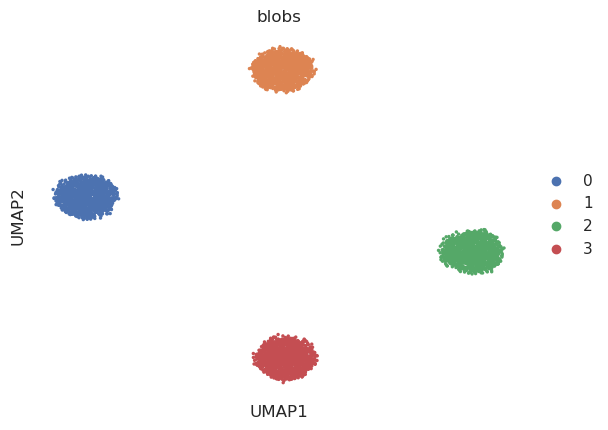

0       2
1       1
2       0
3       2
4       1
       ..
4995    0
4996    2
4997    2
4998    2
4999    0
Name: blobs, Length: 5000, dtype: category
Categories (4, object): ['0', '1', '2', '3']

In [9]:
sc.pl.umap(adata,color='blobs',save='blobs.png')
adata.obs['blobs']

In [10]:
adata_raw = adata.copy()

In [11]:
adata = create_intermediate_state(adata,'blobs',['0','1'])
adata = create_intermediate_state(adata,'blobs',['2','3'])

In [12]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.pca(adata,color='blobs')
sc.pl.pca(adata_raw,color='blobs')


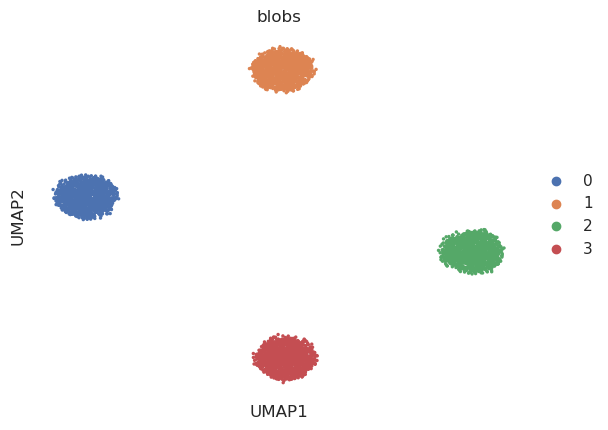

In [13]:
sc.pl.umap(adata_raw,color='blobs',save='blobs_b.png')
sc.pl.umap(adata,color='blobs')


In [14]:
# from numpy import array
# from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
labeles = adata.obs['blobs']
df , were_changed = modify_labels(labeles , probability=0.00)


In [15]:
one_hot_label , inverted_label = one_hot_encode(df['label'])
one_hot_modified_label , inverted_modified = one_hot_encode(df['modified_label'])


['2' '1' '0' ... '2' '2' '0']
[2 1 0 ... 2 2 0]
['2' '1' '0' ... '2' '2' '0']
[2 1 0 ... 2 2 0]


In [16]:
y_train = adata.obs['blobs']
y_train_indices = y_train.unique()
class_sample_count = np.array(
    [sum(y_train == t) for t in y_train_indices])
weight = 1. / class_sample_count
samples_weight= np.zeros(adata.n_obs)
for i in range(adata.n_obs):
    for j, t in enumerate(y_train_indices):
        if adata.obs['blobs'].iloc[i]==t:
            samples_weight[i]=weight[j]
samples_weight = torch.from_numpy(samples_weight)
# samples_weight

In [17]:
# nets_deep = [Net2(adata.X.shape[1],output_size=4),Net3(adata.X.shape[1],output_size=4),Net4(adata.X.shape[1],output_size=4),Net5(adata.X.shape[1],output_size=4)]
# nets_activation = ['relu','tanh','sigmoid']
# num_of_epoch_list = [75,100,125,150]
# learning_rate_list = [0.001,0.002,0.003,0.004]
# batch_size_list = [64,128,256,512]

In [18]:
def train_and_measure_cor_with_change(activation='relu',adata_conf_ref=None,epoch_num=75,lr=0.001,batch_size=128,hiden_layers=2):
    net = Net(adata.X.shape[1],output_size=4,activation=activation,hidden_layers=hiden_layers)
    net.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
    x_data = np.array(adata.X)
    sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))
    tensor_x = torch.Tensor(x_data).to(device) # transform to torch tensor
    # tensor_y_noisy = torch.Tensor(one_hot_modified_label).to(device)
    tensor_y_true = torch.Tensor(one_hot_label).to(device)
    my_dataset = TensorDataset(tensor_x,tensor_y_true) # create your datset

    trainloader = torch.utils.data.DataLoader(my_dataset, batch_size=batch_size,
                                              sampler=sampler, num_workers=0)
    x_only_noisy = torch.tensor(adata[were_changed].X.toarray())
    y_only_noisy = torch.tensor(one_hot_modified_label[were_changed])

    tensor_x = tensor_x.to(device)
    # tensor_y_noisy = tensor_y_noisy.to(device)
    tensor_y_true = tensor_y_true.to(device)
    # x_only_noisy = x_only_noisy.to(device)
    # y_only_noisy = y_only_noisy.to(device)
    prob_loss_list = []
    for epoch in range(epoch_num):  # loop over the dataset multiple times
        outputs_all = net(tensor_x)
        prob_all = probability_for_confidence(outputs_all, tensor_y_true)
        prob_loss_list.append((prob_all.cpu().detach().numpy()))

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # inputs, labels = inputs.cuda(), labels.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 1:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10:.3f}')
                running_loss = 0.0

    print('Finished Training')
    all_conf , all_var = probability_list_to_confidence_and_var(prob_loss_list, n_obs= adata.n_obs, epoch_num=epoch_num)
    adata.obs["conf"] = all_conf.detach().numpy()
    if adata_conf_ref is not None:
        print("ws")
        res = stats.wasserstein_distance(adata.obs['conf'], adata_conf_ref)
        print(res,"wasserstein_distance")
    else:
        res = stats.spearmanr(adata.obs['conf'], adata.obs['change_weight'])
        print(res,"spearmanr correlation")
    return res, all_conf.detach().numpy(), all_var
res, all_conf_ref, all_var = train_and_measure_cor_with_change()
res, all_conf, _ = train_and_measure_cor_with_change(lr=0.0001)

cor_list = []
dict_cor = {}
# for epoch_num in [75,100,125,150]:
#     for activation in ['relu','tanh','sigmoid']:
#         for lt in [0.005,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01]:
#             for batch_size in [64,128,256,512]:
#                 for hiden_layers in [2,3,4]:
#                     res, all_conf, all_var = train_and_measure_cor_with_change(activation,epoch_num=epoch_num,lr=lt,batch_size=batch_size,hiden_layers=hiden_layers)
#                     cor_list.append((activation,lt,batch_size,hiden_layers,res))
#                     dict_cor[(activation,lt,batch_size,hiden_layers,epoch_num)] = (res,all_conf, all_var)

[1,     2] loss: 0.255
[1,    12] loss: 0.665
[1,    22] loss: 0.538
[1,    32] loss: 0.485
[2,     2] loss: 0.098
[2,    12] loss: 0.510
[2,    22] loss: 0.471
[2,    32] loss: 0.475
[3,     2] loss: 0.089
[3,    12] loss: 0.474
[3,    22] loss: 0.443
[3,    32] loss: 0.455
[4,     2] loss: 0.094
[4,    12] loss: 0.437
[4,    22] loss: 0.446
[4,    32] loss: 0.447
[5,     2] loss: 0.091
[5,    12] loss: 0.464
[5,    22] loss: 0.441
[5,    32] loss: 0.430
[6,     2] loss: 0.080
[6,    12] loss: 0.425
[6,    22] loss: 0.414
[6,    32] loss: 0.427
[7,     2] loss: 0.082
[7,    12] loss: 0.447
[7,    22] loss: 0.426
[7,    32] loss: 0.436
[8,     2] loss: 0.101
[8,    12] loss: 0.490
[8,    22] loss: 0.462
[8,    32] loss: 0.449
[9,     2] loss: 0.111
[9,    12] loss: 0.455
[9,    22] loss: 0.413
[9,    32] loss: 0.422
[10,     2] loss: 0.076
[10,    12] loss: 0.408
[10,    22] loss: 0.412
[10,    32] loss: 0.426
[11,     2] loss: 0.107
[11,    12] loss: 0.427
[11,    22] loss: 0.423
[11,

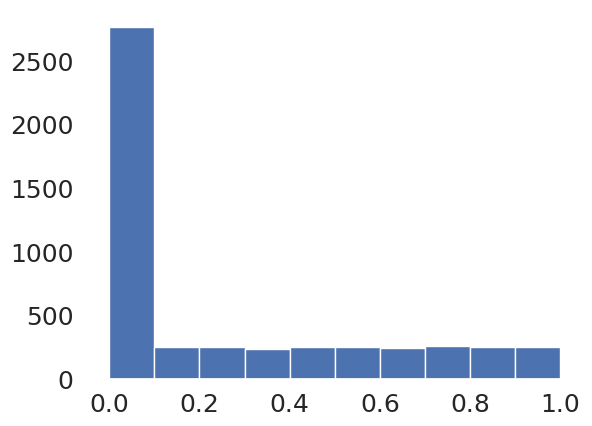

In [19]:
#create a histogram of adata.obs['change_weight'] and plot it to see the distribution
plt.hist(adata.obs['change_weight'], bins=10)
plt.show()

In [20]:
res, all_conf, _ = train_and_measure_cor_with_change(adata_conf_ref=all_conf_ref,lr=0.001)


[1,     2] loss: 0.256
[1,    12] loss: 0.665
[1,    22] loss: 0.512
[1,    32] loss: 0.482
[2,     2] loss: 0.092
[2,    12] loss: 0.492
[2,    22] loss: 0.479
[2,    32] loss: 0.430
[3,     2] loss: 0.086
[3,    12] loss: 0.448
[3,    22] loss: 0.427
[3,    32] loss: 0.458
[4,     2] loss: 0.091
[4,    12] loss: 0.465
[4,    22] loss: 0.441
[4,    32] loss: 0.439
[5,     2] loss: 0.083
[5,    12] loss: 0.435
[5,    22] loss: 0.425
[5,    32] loss: 0.423
[6,     2] loss: 0.090
[6,    12] loss: 0.452
[6,    22] loss: 0.421
[6,    32] loss: 0.444
[7,     2] loss: 0.089
[7,    12] loss: 0.446
[7,    22] loss: 0.456
[7,    32] loss: 0.450
[8,     2] loss: 0.093
[8,    12] loss: 0.420
[8,    22] loss: 0.409
[8,    32] loss: 0.446
[9,     2] loss: 0.092
[9,    12] loss: 0.432
[9,    22] loss: 0.400
[9,    32] loss: 0.427
[10,     2] loss: 0.083
[10,    12] loss: 0.441
[10,    22] loss: 0.445
[10,    32] loss: 0.432
[11,     2] loss: 0.093
[11,    12] loss: 0.461
[11,    22] loss: 0.430
[11,

In [21]:
cor_list

[]

In [22]:
cor_list_lr = []
dict_cor = {}
datas_lr = [] # list of all the data
lr_list_used = []
data_names_lr = []
lr_list = [0.0001,0.00025,0.0005,0.001,0.0025,0.005,0.01]
lr_list_data = [0.0001,0.001,0.005,0.01]
for lr in lr_list:
    temp_list = []
    for i in range(10):
        res, all_conf, all_var = train_and_measure_cor_with_change(lr=lr)
        temp_list.append(res[0])
    cor_list_lr.append(temp_list)
    if lr in lr_list_data:
        data_names_lr.append(lr)
        datas_lr.append(all_conf)
        lr_list_used.append(lr)


[1,     2] loss: 0.273
[1,    12] loss: 1.163
[1,    22] loss: 0.771
[1,    32] loss: 0.610
[2,     2] loss: 0.110
[2,    12] loss: 0.520
[2,    22] loss: 0.526
[2,    32] loss: 0.511
[3,     2] loss: 0.104
[3,    12] loss: 0.522
[3,    22] loss: 0.495
[3,    32] loss: 0.516
[4,     2] loss: 0.100
[4,    12] loss: 0.493
[4,    22] loss: 0.495
[4,    32] loss: 0.517
[5,     2] loss: 0.094
[5,    12] loss: 0.488
[5,    22] loss: 0.501
[5,    32] loss: 0.481
[6,     2] loss: 0.092
[6,    12] loss: 0.501
[6,    22] loss: 0.461
[6,    32] loss: 0.501
[7,     2] loss: 0.099
[7,    12] loss: 0.470
[7,    22] loss: 0.461
[7,    32] loss: 0.486
[8,     2] loss: 0.090
[8,    12] loss: 0.461
[8,    22] loss: 0.458
[8,    32] loss: 0.458
[9,     2] loss: 0.084
[9,    12] loss: 0.469
[9,    22] loss: 0.469
[9,    32] loss: 0.443
[10,     2] loss: 0.093
[10,    12] loss: 0.462
[10,    22] loss: 0.470
[10,    32] loss: 0.464
[11,     2] loss: 0.093
[11,    12] loss: 0.460
[11,    22] loss: 0.436
[11,

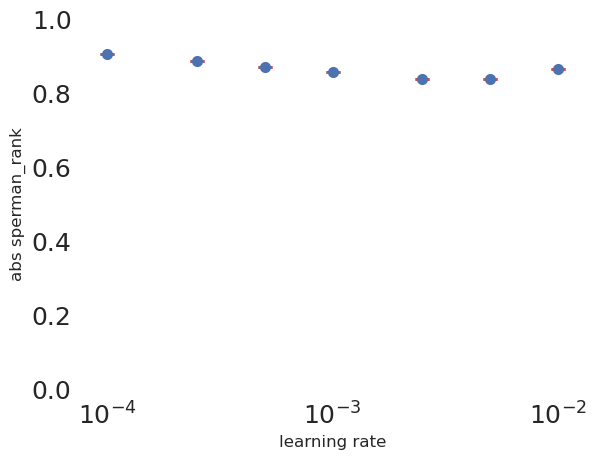

[]

In [23]:

x_axis= lr_list


cor_list_lr = np.abs(np.array(cor_list_lr))

means = np.mean(cor_list_lr, axis=1)
sems = np.std(cor_list_lr, axis=1, ddof=1) / np.sqrt(len(means))
stds = np.std(cor_list_lr, axis=1)
vars = np.var(cor_list_lr, axis=1)
y_axis = means
plt.errorbar(x_axis, y_axis, yerr=vars, fmt='o', ecolor='r', capsize=5, elinewidth=2, markeredgewidth=2)
#added error bars


# plt.errorbar(range(len(means)), means, yerr=sems, fmt='-o', ecolor='r', capsize=5, elinewidth=2, markeredgewidth=2)

plt.xlabel('learning rate')
plt.ylabel('abs sperman_rank')
# plt.xlim(0.0000,0.01)
plt.ylim(0,1)
# all_conf.shape
# plt.scatter(all_conf, all_conf_ref,s=1)
# plt.xlabel('conf_lr_0.0001')
# plt.ylabel('conf_lr_0.001')
#show x axis in log 2
plt.xscale('log')
plt.show()
cor_list

In [24]:
# _, _, _ = train_and_measure_cor_with_change(epoch_num=1000,lr=0.00001,batch_size=128*4)


In [25]:
sns.set_theme()
import matplotlib as mpl

plt.rcParams.update({'font.size': 18,
                     'xtick.labelsize' : 18,
                     'ytick.labelsize' : 18})

mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['axes.facecolor'] = 'white'


In [26]:
# Generate random datasets with the provided names
data_names = data_names_lr
datasets = datas_lr
# plt.style.use('default')
# Create a scatter plot for each dataset using a different shade of blue
num_datasets = len(data_names)

plt.figure(figsize=(14, 10))
cmap = plt.cm.Blues
colors = plt.cm.viridis(np.linspace(0, 1, num_datasets))
x = adata.obs['change_weight']
for i, data in enumerate(datasets):
    if i == 0:
        plt.scatter(x, data, color="blue", label=f'lr {data_names[i]}',s=1)
    else:
        plt.scatter(x, data, color=colors[i], label=f'lr {data_names[i]}',s=1)

# Add titles, labels, and legend
# plt.title('Scatter Plot of Multiple Datasets with Blue Color Scale')
plt.xlabel('change_weight')
plt.ylabel('conf')
plt.legend(title='Datasets', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.show()


In [27]:
cor_list_batch = []
datas_batch = [] # list of all the data
batch_list_used = []
# batch_names = []
batch_list = [64,100,128,150,200,256,300,350,400,450,500,512]
batch_list_data =  [64,128,256,512]
for batch_size in batch_list:
    temp_list = []
    for i in range(10):
        res, all_conf, all_var = train_and_measure_cor_with_change(batch_size=batch_size)
        temp_list.append(res[0])
    cor_list_batch.append(temp_list)
    if batch_size in batch_list_data:
        batch_list_used.append(batch_size)
        datas_batch.append(all_conf)



[1,     2] loss: 0.286
[1,    12] loss: 0.749
[1,    22] loss: 0.496
[1,    32] loss: 0.494
[1,    42] loss: 0.488
[1,    52] loss: 0.446
[1,    62] loss: 0.459
[1,    72] loss: 0.451
[2,     2] loss: 0.108
[2,    12] loss: 0.490
[2,    22] loss: 0.454
[2,    32] loss: 0.467
[2,    42] loss: 0.465
[2,    52] loss: 0.416
[2,    62] loss: 0.483
[2,    72] loss: 0.455
[3,     2] loss: 0.095
[3,    12] loss: 0.433
[3,    22] loss: 0.441
[3,    32] loss: 0.431
[3,    42] loss: 0.441
[3,    52] loss: 0.442
[3,    62] loss: 0.441
[3,    72] loss: 0.454
[4,     2] loss: 0.090
[4,    12] loss: 0.458
[4,    22] loss: 0.444
[4,    32] loss: 0.448
[4,    42] loss: 0.428
[4,    52] loss: 0.403
[4,    62] loss: 0.463
[4,    72] loss: 0.444
[5,     2] loss: 0.084
[5,    12] loss: 0.489
[5,    22] loss: 0.464
[5,    32] loss: 0.467
[5,    42] loss: 0.463
[5,    52] loss: 0.417
[5,    62] loss: 0.442
[5,    72] loss: 0.467
[6,     2] loss: 0.093
[6,    12] loss: 0.488
[6,    22] loss: 0.419
[6,    32] 

In [28]:

x_axis= batch_list

cor_list_batch = np.abs(np.array(cor_list_batch))
means = np.mean(cor_list_batch, axis=1)
sems = np.std(cor_list_batch, axis=1, ddof=1) / np.sqrt(len(means))
stds = np.std(cor_list_batch, axis=1)
vars = np.var(cor_list_batch, axis=1)
y_axis = means

plt.errorbar(x_axis, y_axis, yerr=vars, fmt='o', ecolor='r', capsize=5, elinewidth=2, markeredgewidth=2)
plt.ylabel('abs sperman_rank')
# plt.xlim(0.0000,0.01)
plt.ylim(0,1)
plt.xlabel('batch size')


Text(0.5, 0, 'batch size')

In [29]:
# Generate random datasets with the provided names
data_names = batch_list_used
datasets = datas_batch
# plt.style.use('default')
# Create a scatter plot for each dataset using a different shade of blue
num_datasets = len(data_names)

plt.figure(figsize=(14, 10))
cmap = plt.cm.Blues
colors = plt.cm.viridis(np.linspace(0, 1, num_datasets))
x = adata.obs['change_weight']
for i, data in enumerate(datasets):
    if i == len(datasets)-1:
        plt.scatter(x, data, color="blue", label=f'batch size {data_names[i]}',s=1)
    else:
        plt.scatter(x, data, color=colors[i], label=f'batch size {data_names[i]}',s=1)

# Add titles, labels, and legend
# plt.title('Scatter Plot of Multiple Datasets with Blue Color Scale')
plt.xlabel('change_weight')
plt.ylabel('conf')
plt.legend(title='Datasets', bbox_to_anchor=(1.05, 1), loc='upper left')

[1,     2] loss: 0.278
[1,    12] loss: 0.691
[1,    22] loss: 0.535
[1,    32] loss: 0.499
[2,     2] loss: 0.089
[2,    12] loss: 0.493
[2,    22] loss: 0.434
[2,    32] loss: 0.475
[3,     2] loss: 0.094
[3,    12] loss: 0.462
[3,    22] loss: 0.449
[3,    32] loss: 0.467
[4,     2] loss: 0.102
[4,    12] loss: 0.458
[4,    22] loss: 0.428
[4,    32] loss: 0.433
[5,     2] loss: 0.077
[5,    12] loss: 0.450
[5,    22] loss: 0.457
[5,    32] loss: 0.431
[6,     2] loss: 0.090
[6,    12] loss: 0.437
[6,    22] loss: 0.410
[6,    32] loss: 0.435
[7,     2] loss: 0.087
[7,    12] loss: 0.447
[7,    22] loss: 0.440
[7,    32] loss: 0.419
[8,     2] loss: 0.084
[8,    12] loss: 0.435
[8,    22] loss: 0.432
[8,    32] loss: 0.417
[9,     2] loss: 0.085
[9,    12] loss: 0.426
[9,    22] loss: 0.426
[9,    32] loss: 0.438
[10,     2] loss: 0.090
[10,    12] loss: 0.469
[10,    22] loss: 0.410
[10,    32] loss: 0.414
[11,     2] loss: 0.088
[11,    12] loss: 0.423
[11,    22] loss: 0.415
[11,

Text(0.5, 0, 'hidden layers')

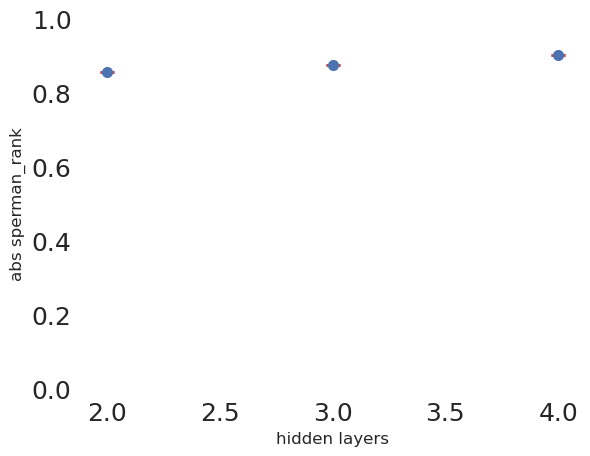

In [30]:
cor_list_hidden = []
datas_hidden = [] # list of all the data
hidden_list_used = []
# batch_names = []
hidden_list = [2,3,4]
hidden_list_data =  hidden_list
for hidden in hidden_list:
    temp_list = []
    for i in range(10):
        res, all_conf, all_var = train_and_measure_cor_with_change(hiden_layers=hidden)
        temp_list.append(res[0])
    cor_list_hidden.append(temp_list)
    if hidden in hidden_list_data:
        hidden_list_used.append(hidden)
        datas_hidden.append(all_conf)
x_axis= hidden_list

cor_list_hidden = np.abs(np.array(cor_list_hidden))
means = np.mean(cor_list_hidden, axis=1)
sems = np.std(cor_list_hidden, axis=1, ddof=1) / np.sqrt(len(means))
stds = np.std(cor_list_hidden, axis=1)
vars = np.var(cor_list_hidden, axis=1)
y_axis = means

plt.errorbar(x_axis, y_axis, yerr=vars, fmt='o', ecolor='r', capsize=5, elinewidth=2, markeredgewidth=2)
plt.ylabel('abs sperman_rank')
# plt.xlim(0.0000,0.01)
plt.ylim(0,1)
plt.xlabel('hidden layers')

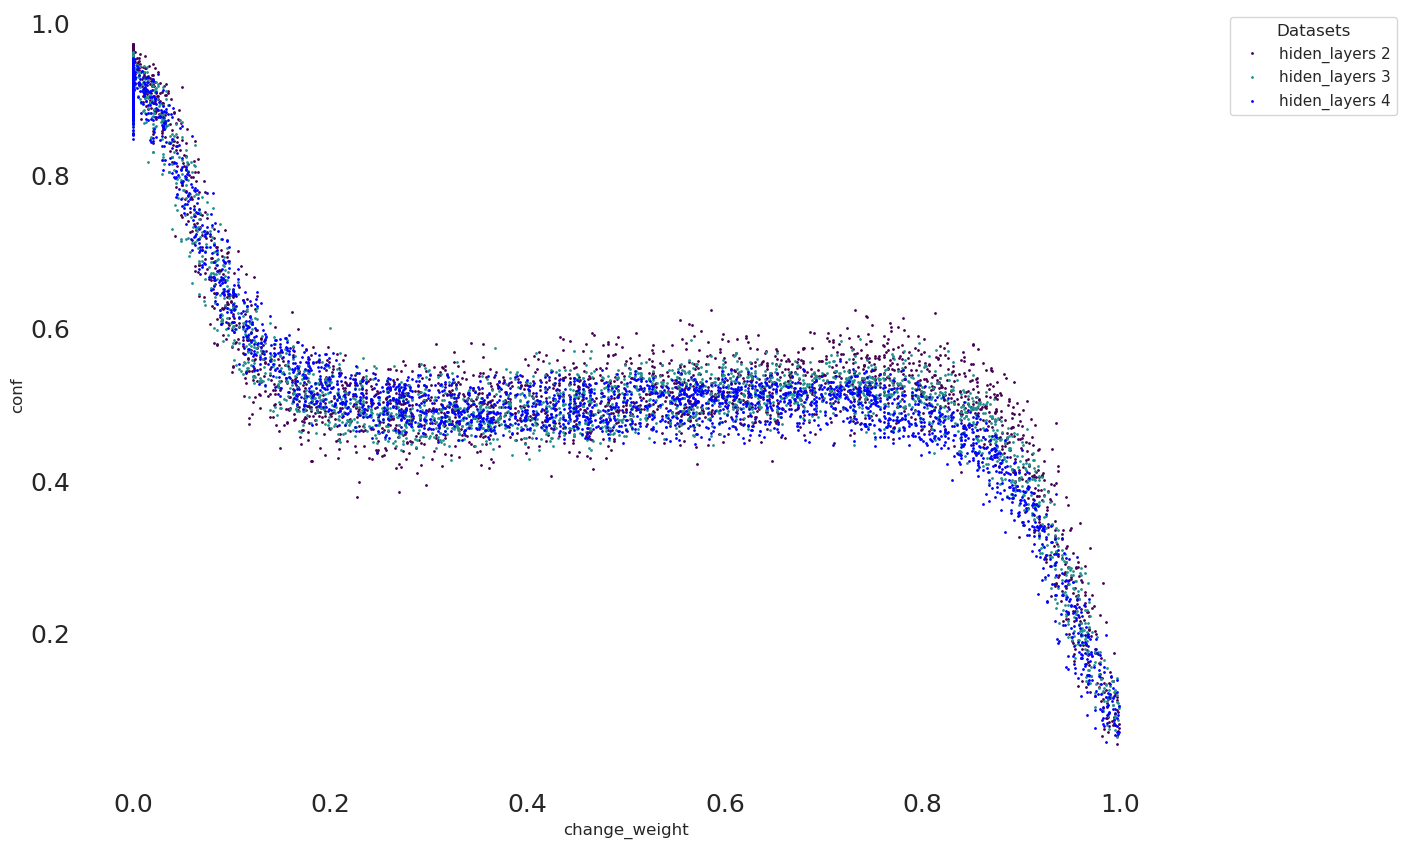

In [31]:
# Generate random datasets with the provided names
data_names = hidden_list_used
datasets = datas_hidden
# plt.style.use('default')
# Create a scatter plot for each dataset using a different shade of blue
num_datasets = len(data_names)

plt.figure(figsize=(14, 10))
cmap = plt.cm.Blues
colors = plt.cm.viridis(np.linspace(0, 1, num_datasets))
x = adata.obs['change_weight']
for i, data in enumerate(datasets):
    if i == len(datasets)-1:
        plt.scatter(x, data, color="blue", label=f'hiden_layers {data_names[i]}',s=1)
    else:
        plt.scatter(x, data, color=colors[i], label=f'hiden_layers {data_names[i]}',s=1)

# Add titles, labels, and legend
# plt.title('Scatter Plot of Multiple Datasets with Blue Color Scale')
plt.xlabel('change_weight')
plt.ylabel('conf')
plt.legend(title='Datasets', bbox_to_anchor=(1.05, 1), loc='upper left')

In [32]:
# cor_list

[1,     2] loss: 0.318
[1,    12] loss: 0.758
[1,    22] loss: 0.540
[1,    32] loss: 0.500
[2,     2] loss: 0.087
[2,    12] loss: 0.511
[2,    22] loss: 0.475
[2,    32] loss: 0.506
[3,     2] loss: 0.111
[3,    12] loss: 0.468
[3,    22] loss: 0.490
[3,    32] loss: 0.423
[4,     2] loss: 0.097
[4,    12] loss: 0.441
[4,    22] loss: 0.446
[4,    32] loss: 0.447
[5,     2] loss: 0.095
[5,    12] loss: 0.449
[5,    22] loss: 0.445
[5,    32] loss: 0.431
[6,     2] loss: 0.087
[6,    12] loss: 0.414
[6,    22] loss: 0.473
[6,    32] loss: 0.443
[7,     2] loss: 0.099
[7,    12] loss: 0.471
[7,    22] loss: 0.442
[7,    32] loss: 0.414
[8,     2] loss: 0.090
[8,    12] loss: 0.439
[8,    22] loss: 0.438
[8,    32] loss: 0.437
[9,     2] loss: 0.086
[9,    12] loss: 0.429
[9,    22] loss: 0.406
[9,    32] loss: 0.450
[10,     2] loss: 0.085
[10,    12] loss: 0.475
[10,    22] loss: 0.438
[10,    32] loss: 0.417
[11,     2] loss: 0.092
[11,    12] loss: 0.481
[11,    22] loss: 0.462
[11,

Text(0.5, 0, 'epoch number')

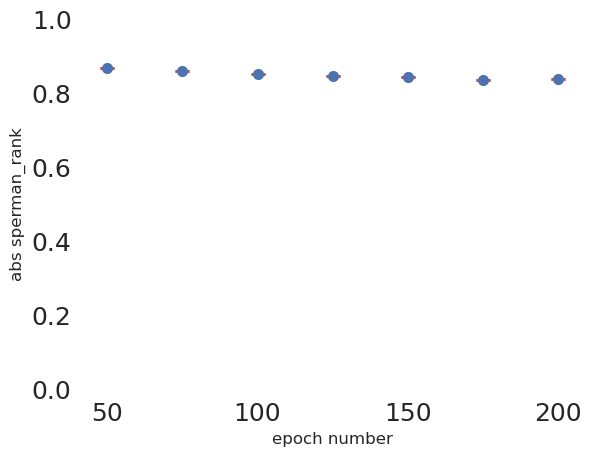

In [33]:
cor_list_epoch = []
datas_epoch_num = [] # list of all the data
epoch_num_list_used = []
epoch_list_data =  [75,125,150,200]
hidden_list_data =  hidden_list
epoch_num_list = [50,75,100,125,150,175,200]
for epoch_num in epoch_num_list:
    temp_list = []
    for i in range(10):
        res, all_conf, all_var = train_and_measure_cor_with_change(epoch_num=epoch_num)
        temp_list.append(res[0])
    cor_list_epoch.append(temp_list)
    if epoch_num in epoch_list_data:
        epoch_num_list_used.append(epoch_num)
        datas_epoch_num.append(all_conf)

x_axis = epoch_num_list
cor_list_epoch = np.abs(np.array(cor_list_epoch))
means = np.mean(cor_list_epoch, axis=1)
sems = np.std(cor_list_epoch, axis=1, ddof=1) / np.sqrt(len(means))
stds = np.std(cor_list_epoch, axis=1)
vars = np.var(cor_list_epoch, axis=1)
y_axis = means

plt.errorbar(x_axis, y_axis, yerr=vars, fmt='o', ecolor='r', capsize=5, elinewidth=2, markeredgewidth=2)
plt.ylabel('abs sperman_rank')
# plt.xlim(0.0000,0.01)
plt.ylim(0,1)
plt.xlabel('epoch number')



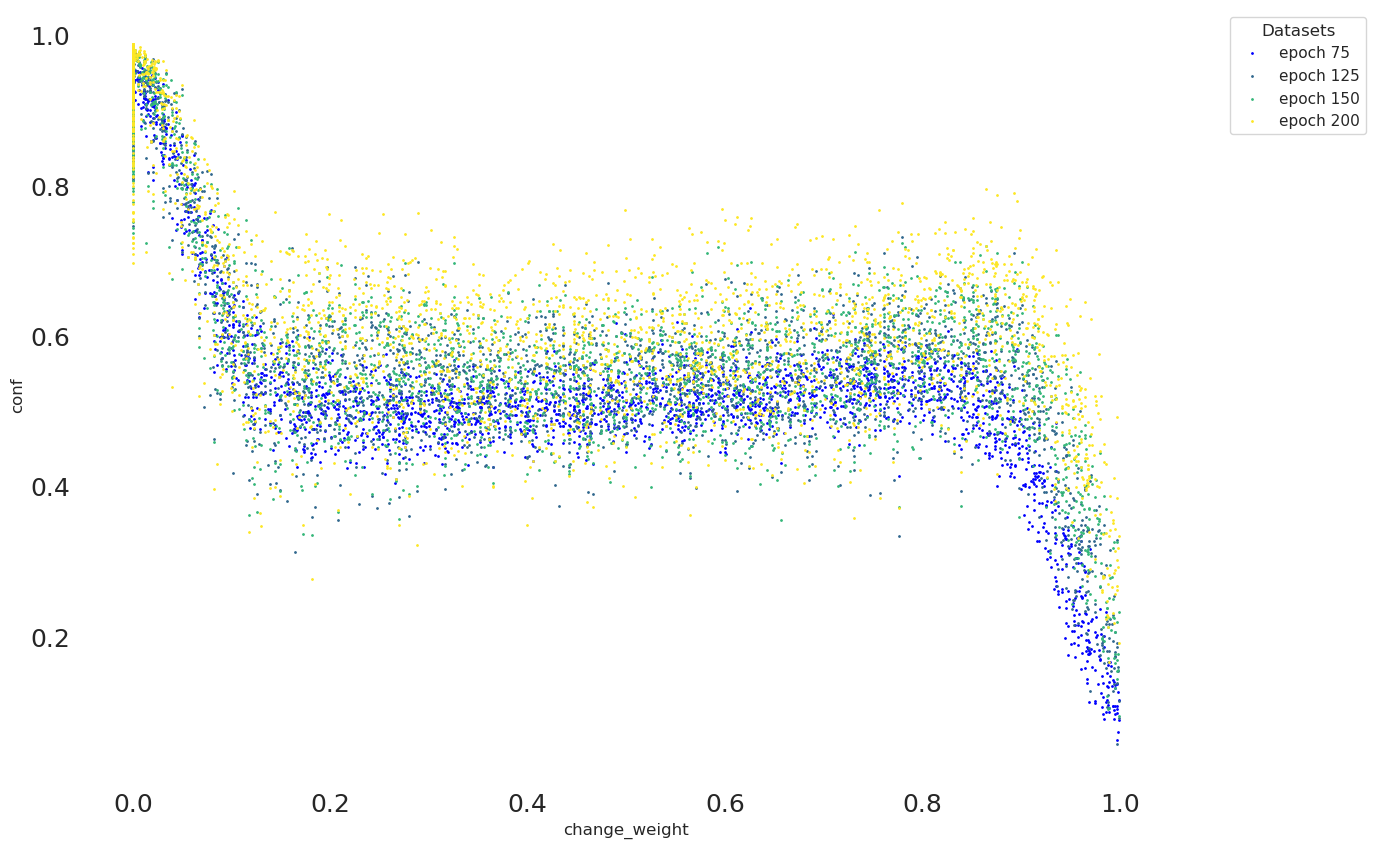

In [34]:
# Generate random datasets with the provided names
data_names = epoch_num_list_used
datasets = datas_epoch_num
num_datasets = len(data_names)

plt.figure(figsize=(14, 10))
cmap = plt.cm.Blues
colors = plt.cm.viridis(np.linspace(0, 1, num_datasets))
x = adata.obs['change_weight']
for i, data in enumerate(datasets):
    if i == 0:
        plt.scatter(x, data, color="blue", label=f'epoch {data_names[i]}',s=1)
    else:
        plt.scatter(x, data, color=colors[i], label=f'epoch {data_names[i]}',s=1)

# Add titles, labels, and legend
# plt.title('Scatter Plot of Multiple Datasets with Blue Color Scale')
plt.xlabel('change_weight')
plt.ylabel('conf')
plt.legend(title='Datasets', bbox_to_anchor=(1.05, 1), loc='upper left')

In [35]:
were_changed

(array([], dtype=int64),)

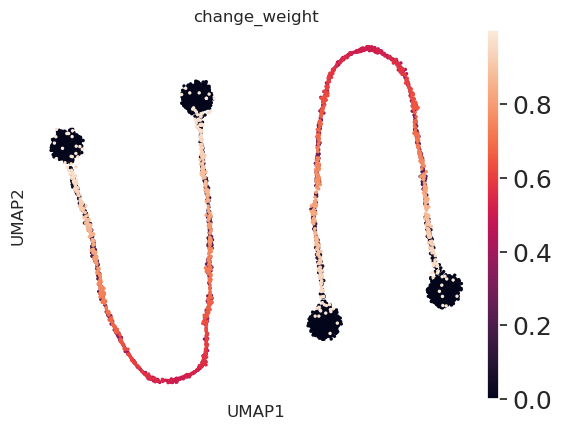

In [36]:
sc.pl.umap(adata,color=['conf',"blobs"])
sc.pl.umap(adata,color='conf',save='conf.png')
sc.pl.umap(adata,color='change_weight',save='change_weight.png')


In [37]:
res = stats.pearsonr(adata.obs['change_weight'], adata.obs['conf'])
print(res)
#plot
plt.scatter(adata.obs['change_weight'], adata.obs['conf'],s=1)
plt.xlim(0.3,0.4)
plt.ylim(0.9,1)
plt.xlabel('change_weight')
plt.ylabel('confidence')


PearsonRResult(statistic=-0.8037409961632316, pvalue=0.0)


Text(0, 0.5, 'confidence')

Text(0, 0.5, 'confidence')

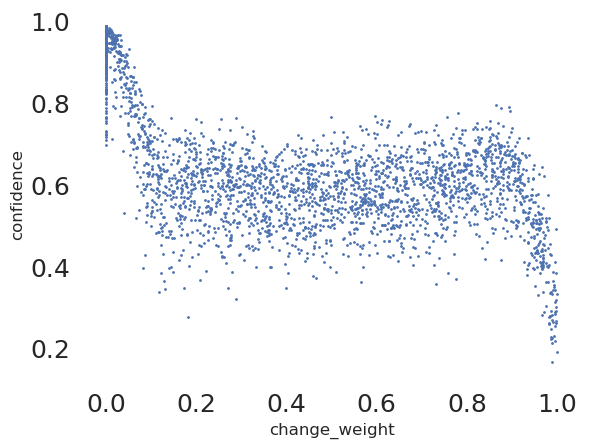

In [38]:
plt.scatter(adata.obs['change_weight'], adata.obs['conf'],s=1)
# plt.xlim(0.3,0.4)
# plt.ylim(0.9,1)
plt.xlabel('change_weight')
plt.ylabel('confidence')

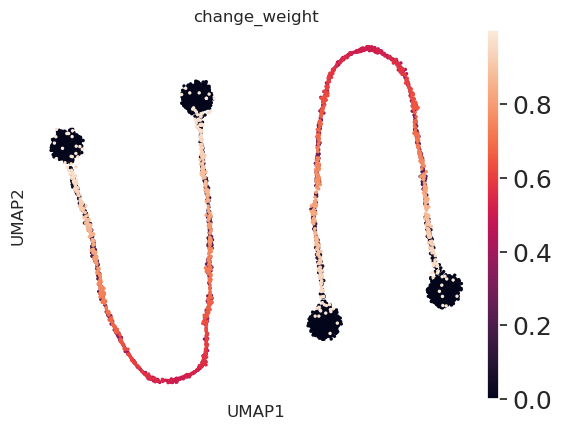

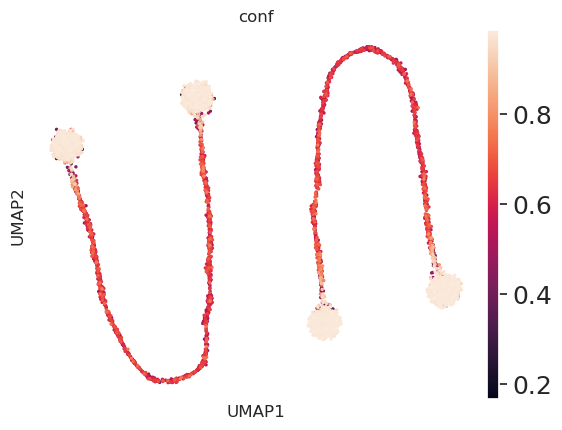

In [39]:
sc.pl.umap(adata,color='change_weight')
sc.pl.umap(adata,color='conf')


[1,     2] loss: 0.288
[1,    12] loss: 0.678
[1,    22] loss: 0.525
[1,    32] loss: 0.472
[2,     2] loss: 0.107
[2,    12] loss: 0.454
[2,    22] loss: 0.453
[2,    32] loss: 0.440
[3,     2] loss: 0.096
[3,    12] loss: 0.422
[3,    22] loss: 0.460
[3,    32] loss: 0.444
[4,     2] loss: 0.078
[4,    12] loss: 0.421
[4,    22] loss: 0.441
[4,    32] loss: 0.416
[5,     2] loss: 0.106
[5,    12] loss: 0.473
[5,    22] loss: 0.444
[5,    32] loss: 0.399
[6,     2] loss: 0.090
[6,    12] loss: 0.413
[6,    22] loss: 0.442
[6,    32] loss: 0.458
[7,     2] loss: 0.092
[7,    12] loss: 0.469
[7,    22] loss: 0.439
[7,    32] loss: 0.427
[8,     2] loss: 0.092
[8,    12] loss: 0.441
[8,    22] loss: 0.406
[8,    32] loss: 0.419
[9,     2] loss: 0.084
[9,    12] loss: 0.428
[9,    22] loss: 0.435
[9,    32] loss: 0.420
[10,     2] loss: 0.085
[10,    12] loss: 0.475
[10,    22] loss: 0.430
[10,    32] loss: 0.445
[11,     2] loss: 0.082
[11,    12] loss: 0.452
[11,    22] loss: 0.444
[11,

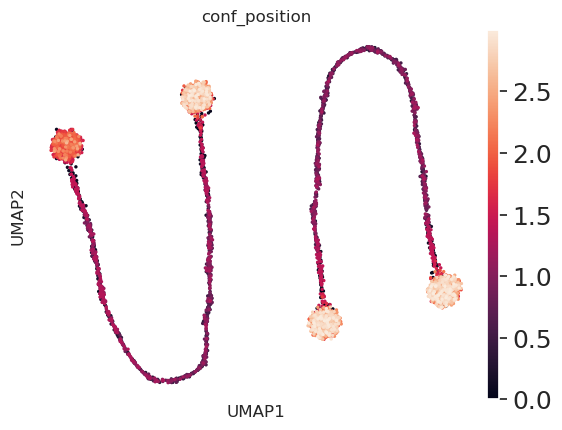

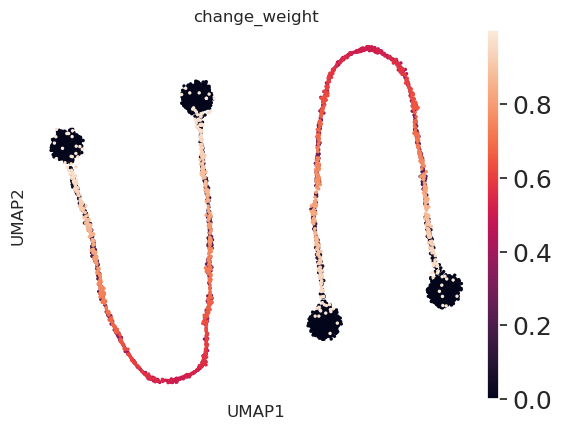

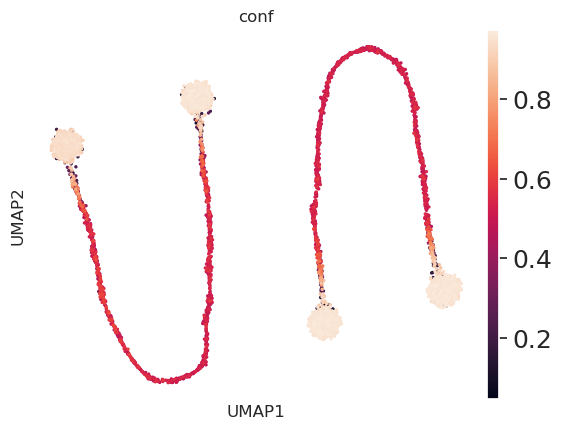

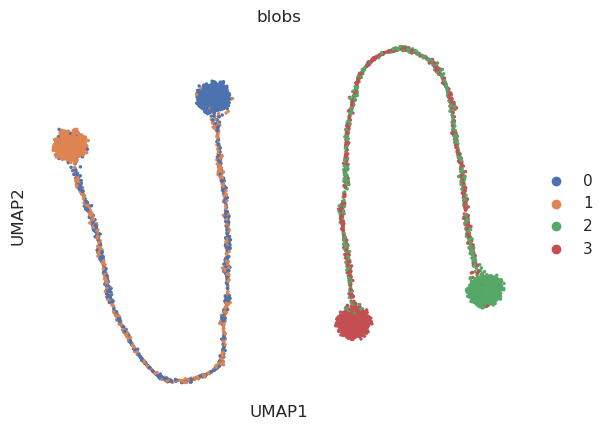

In [40]:
import metrics
res, all_conf, all_var = train_and_measure_cor_with_change()

adata.obs["conf"] = all_conf
adata.obs["var"] = all_var

sorted_indices_conf = np.argsort(adata.obs['conf'])
positions_conf = np.empty_like(sorted_indices_conf)
positions_conf[sorted_indices_conf] = np.arange(len((adata.obs['conf'])))
n = len(sorted_indices_conf)

mean_distance_conf = metrics.mean_absolute_distance(n)

adata.obs['conf_position'] = positions_conf/mean_distance_conf

sc.pl.umap(adata,color='conf_position')
sc.pl.umap(adata,color='change_weight')
sc.pl.umap(adata,color='conf')
sc.pl.umap(adata,color='blobs')


(4,)
0
1
2
3


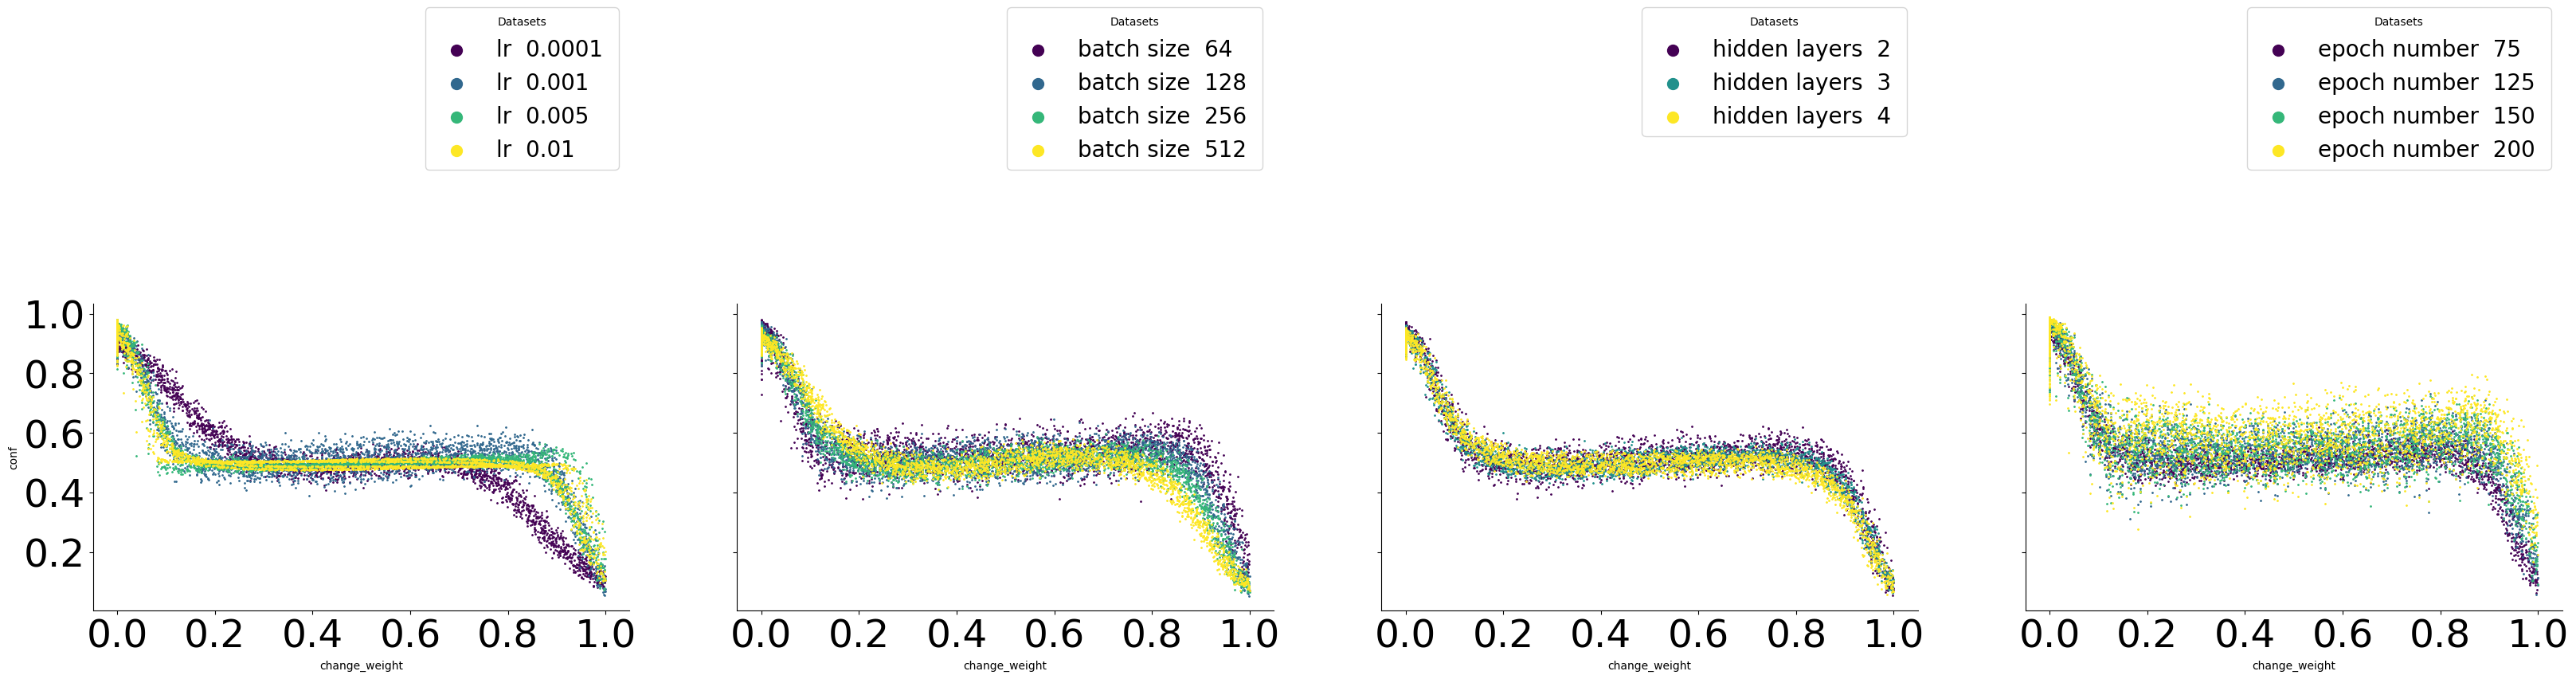

In [41]:
plt.rcParams.update(plt.rcParamsDefault)
datas = [datas_lr,datas_batch,datas_hidden,datas_epoch_num]
data_names = [lr_list_used,batch_list_used,hidden_list_used,epoch_num_list_used]
data_names_list_of_lists = [lr_list_used,batch_list_used,hidden_list_used,epoch_num_list_used]
names = ['lr ','batch size ','hidden layers ','epoch number ' ]
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(40, 5), sharex=True, sharey=True)
print(axes.shape)
for i,data in enumerate(datas):
    data_names = data_names_list_of_lists[i]
    ax = axes[i]
    # data_name = data_names[i]
    datasets = data
    num_datasets = len(datasets)
    colors = plt.cm.viridis(np.linspace(0, 1, num_datasets))
    x = adata.obs['change_weight']
    name = names[i]
    for j, data in enumerate(datasets):
        current_color = colors[j]
        if i == 0:
            ax.set_ylabel('conf')
            ax.set_yticks(np.arange(0.0, 1.2, step=0.2))
        if name == 'lr ':
            ax.set_xlabel('learning rate')
            # if j == 0:
            #     current_color = 'blue'
        elif name == 'batch size ':
            ax.set_xlabel('batch size')
            # if j == len(datasets)-1:
            #     current_color = 'blue'
        elif name == 'hidden layers ':
            ax.set_xlabel('hidden layers')
            # if j == len(datasets)-1:
            #     current_color = 'blue'
        elif name == 'epoch number ':
            ax.set_xlabel('epoch number')
            # if j == 0:
            #     current_color = 'blue'
        ax.scatter(x, data, color=current_color, label=f'{name} {data_names[j]} ',s=1)

# Add titles, labels, and legend
# plt.title('Scatter Plot of Multiple Datasets with Blue Color Scale')
    ax.set_xlabel('change_weight')
    ax.legend(title='Datasets', loc='upper right', bbox_to_anchor=(1, 2),fontsize=20,markerscale=10)
    # legend = axes[0].legend(handles, labels, title="Legend", scatterpoints=1, loc="upper left", fontsize=15, title_fontsize=18, markerscale=2)


    ax.tick_params(axis='both', labelsize=35)

    # ax.set_title(f'{cond}',fontsize=20)
    #change tikers to be 0.1 till 0.5
    ax.set_xticks(np.arange(0.0, 1.2, step=0.2))
    #change tikers font size
    # for tick in ax.xaxis.get_major_ticks():
    #     tick.label.set_fontsize(20)
    print(i)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

plt.savefig(f'figures/sup_sens_a_44.png',dpi=600)
plt.savefig(f'figures/sup_sens_b.svg',dpi=600,format='svg')
plt.show()

# plt.savefig(f'figures/a_high_res.png',dpi=100)
#     plt.show()

sns.set_theme()
# plt.rcParams.update(plt.rcParamsDefault)

plt.rcParams.update({'font.size': 18,
                     'xtick.labelsize' : 18,
                     'ytick.labelsize' : 18})

mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['axes.facecolor'] = 'white'

In [42]:
cor_list_epoch = np.abs(np.array(cor_list_epoch))
means_epoch = np.mean(cor_list_epoch, axis=1)
sems_epoch = np.std(cor_list_epoch, axis=1, ddof=1) / np.sqrt(len(means))
stds_epochs = np.std(cor_list_epoch, axis=1)
vars_epochs = np.var(cor_list_epoch, axis=1)

cor_list_hidden = np.abs(np.array(cor_list_hidden))
means_hidden = np.mean(cor_list_hidden, axis=1)
sems_hidden = np.std(cor_list_hidden, axis=1, ddof=1) / np.sqrt(len(means))
stds_hidden = np.std(cor_list_hidden, axis=1)
vars_hidden = np.var(cor_list_hidden, axis=1)

cor_list_batch = np.abs(np.array(cor_list_batch))
means_batch = np.mean(cor_list_batch, axis=1)
sems_batch = np.std(cor_list_batch, axis=1, ddof=1) / np.sqrt(len(means))
stds_batch = np.std(cor_list_batch, axis=1)
vars_batch = np.var(cor_list_batch, axis=1)

cor_list_lr = np.abs(np.array(cor_list_lr))
means_lr = np.mean(cor_list_lr, axis=1)
sems_lr = np.std(cor_list_lr, axis=1, ddof=1) / np.sqrt(len(means))
stds_lr = np.std(cor_list_lr, axis=1)
vars_lr = np.var(cor_list_lr, axis=1)


(4,)
[0.0001, 0.00025, 0.0005, 0.001, 0.0025, 0.005, 0.01]
[0.9072169  0.88756974 0.87134123 0.85663383 0.83902713 0.84005106
 0.86664348]
0
[64, 100, 128, 150, 200, 256, 300, 350, 400, 450, 500, 512]
[0.84341093 0.85269629 0.85785618 0.85974263 0.86424298 0.8728156
 0.87777333 0.88003414 0.883709   0.88625083 0.89198503 0.8918645 ]
1
[2, 3, 4]
[0.85551257 0.87528267 0.90155302]
2
[50, 75, 100, 125, 150, 175, 200]
[0.86692407 0.85902538 0.85060003 0.84604243 0.84207988 0.83492572
 0.83587451]
3


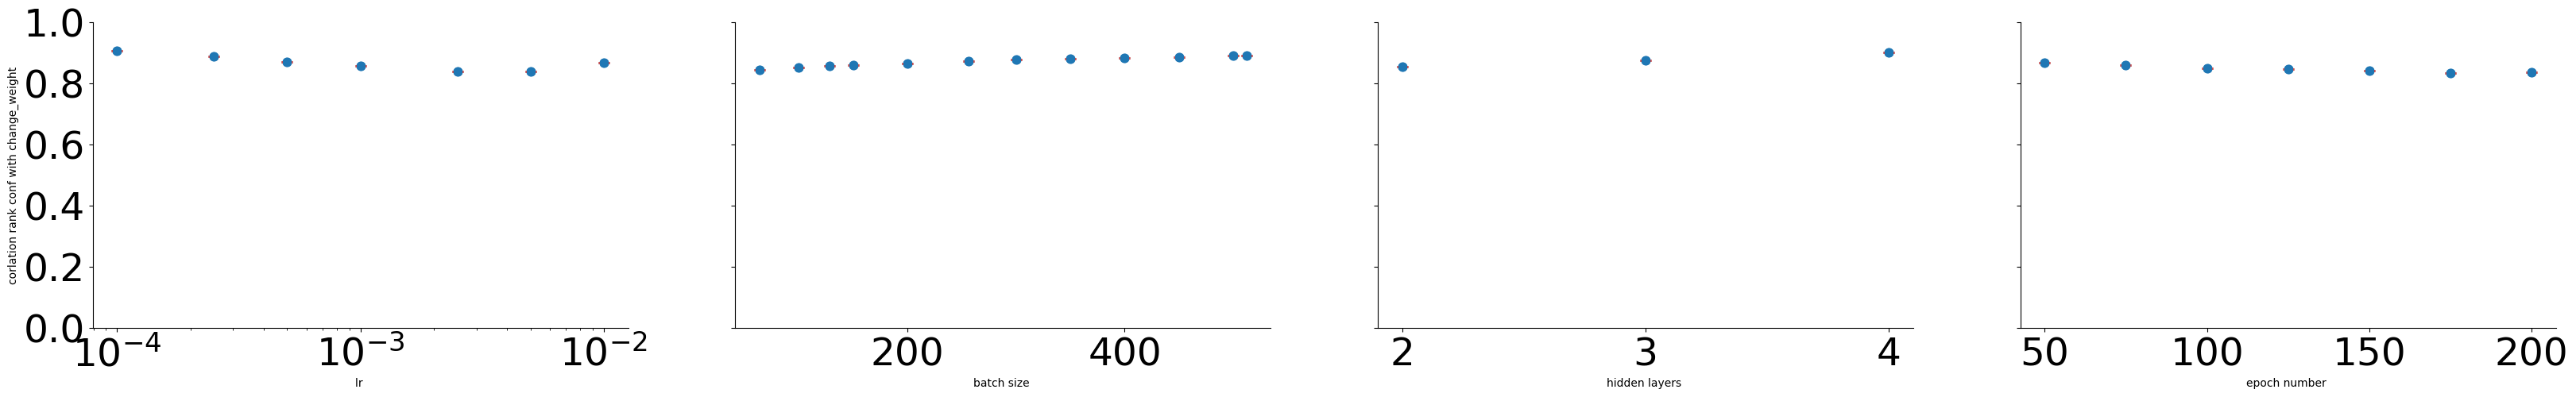

0.8390271343446294 0.9072168967872901
0.8434109340948097 0.8919850323262779
0.8555125678000115 0.9015530195684127
0.8349257155149339 0.8669240721670304


In [43]:
plt.rcParams.update(plt.rcParamsDefault)
datas = [means_lr,means_batch,means_hidden,means_epoch]
names = ['lr ','batch size ','hidden layers ','epoch number ' ]
error_bar_list = [vars_lr,vars_batch,vars_hidden,vars_epochs]
x_axis_list_of_lists = [lr_list, batch_list, hidden_list, epoch_num_list]
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(40, 5), sharey=True)
print(axes.shape)
for i,data in enumerate(datas):
    ax = axes[i]
    datasets = data
    name = names[i]
    if i == 0:
        ax.set_ylabel('corlation rank conf with change_weight')
    x_axis = x_axis_list_of_lists[i]
    print(x_axis)
    y_axis = datasets
    ax.scatter(x_axis,y_axis,s=60)
    vars = error_bar_list[i]
    ax.errorbar(x_axis, y_axis, yerr=vars, fmt='o', ecolor='r', capsize=5, elinewidth=2, markeredgewidth=2)

    ax.set_xlabel(f'{name}')

    ax.set_yticks(np.arange(0,1.2, step=0.2))
    # ax.set_xlim(min(x_axis), max(x_axis))
    print(data)

    ax.tick_params(axis='both', labelsize=35)

    # ax.set_xticks(x_axis)  # Adjust this as needed
    if i ==  0:
        #set  x axis log 2
        ax.set_xscale('log')
    # ax.set_xlim(min(x_axis), max(x_axis))

    # ax.set_title(f'{cond}',fontsize=20)
    #change tikers to be 0.1 till 0.5
    # ax.set_xticks(np.arange(0.0, 0.6, step=0.1))
    #change tikers font size
    # for tick in ax.xaxis.get_major_ticks():
    #     tick.label.set_fontsize(20)
    print(i)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # plt.ylim(-1,0)
plt.savefig(f'figures/sup_sens_c.png',dpi=600)
plt.savefig(f'figures/sup_sens_c.svg',dpi=600,format='svg')

plt.show()
# plt.savefig(f'figures/b_v3_sup.png',dpi=600)
# plt.savefig(f'figures/b_v3_sup.svg',dpi=600,format='svg')

# plt.savefig(f'figures/a_high_res.png',dpi=100)
#     plt.show()

sns.set_theme()
# plt.rcParams.update(plt.rcParamsDefault)

plt.rcParams.update({'font.size': 18,
                     'xtick.labelsize' : 18,
                     'ytick.labelsize' : 18})

mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['axes.facecolor'] = 'white'

#print the min and mad from datas
print(np.min(means_lr),np.max(means_lr))
print(np.min(means_batch),np.max(means_batch))
print(np.min(means_hidden),np.max(means_hidden))
print(np.min(means_epoch),np.max(means_epoch))


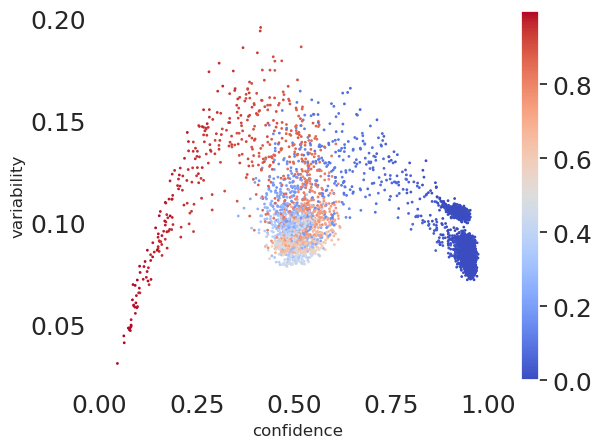

In [44]:
#plot conf and var colored by change_weight
plt.scatter(adata.obs['conf'], adata.obs['var'],c=adata.obs['change_weight'], cmap='coolwarm',s=1)
plt.xlabel('confidence')
plt.ylabel('variability')
plt.colorbar()
plt.show()

[1,     2] loss: 0.318
[2,     2] loss: 0.318
[3,     2] loss: 0.311
[4,     2] loss: 0.299
[5,     2] loss: 0.281
[6,     2] loss: 0.275
[7,     2] loss: 0.262
[8,     2] loss: 0.248
[9,     2] loss: 0.236
[10,     2] loss: 0.232
[11,     2] loss: 0.221
[12,     2] loss: 0.215
[13,     2] loss: 0.207
[14,     2] loss: 0.203
[15,     2] loss: 0.197
[16,     2] loss: 0.189
[17,     2] loss: 0.185
[18,     2] loss: 0.178
[19,     2] loss: 0.175
[20,     2] loss: 0.174
[21,     2] loss: 0.170
[22,     2] loss: 0.165
[23,     2] loss: 0.165
[24,     2] loss: 0.159
[25,     2] loss: 0.159
[26,     2] loss: 0.153
[27,     2] loss: 0.153
[28,     2] loss: 0.153
[29,     2] loss: 0.146
[30,     2] loss: 0.142
[31,     2] loss: 0.141
[32,     2] loss: 0.143
[33,     2] loss: 0.140
[34,     2] loss: 0.138
[35,     2] loss: 0.137
[36,     2] loss: 0.139
[37,     2] loss: 0.137
[38,     2] loss: 0.131
[39,     2] loss: 0.134
[40,     2] loss: 0.134
[41,     2] loss: 0.130
[42,     2] loss: 0.133
[

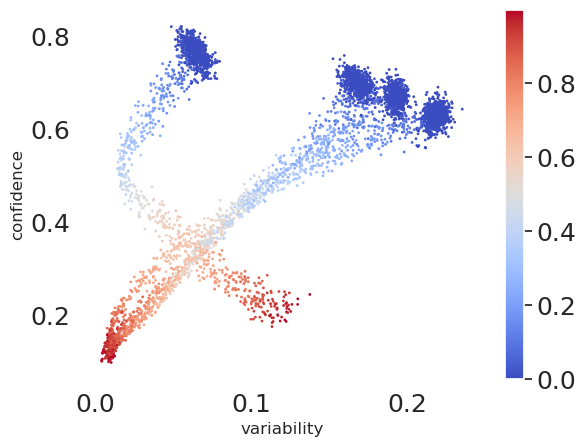

In [45]:
res, all_conf, all_var = train_and_measure_cor_with_change(lr=0.00001,epoch_num=100,batch_size=128*8,hiden_layers=2)

adata.obs["conf"] = all_conf
adata.obs["var"] = all_var
# plt.scatter(adata.obs['conf'], adata.obs['var'],c=adata.obs['change_weight'], cmap='coolwarm',s=1)
plt.scatter( adata.obs['var'],adata.obs['conf'],c=adata.obs['change_weight'], cmap='coolwarm',s=1)
plt.xlabel('variability')
plt.ylabel('confidence')
plt.colorbar()
plt.show()

In [46]:
adata

AnnData object with n_obs × n_vars = 5000 × 1000
    obs: 'blobs', 'change_weight', 'conf', 'var', 'conf_position'
    uns: 'pca', 'neighbors', 'umap', 'blobs_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [47]:
cor_list_activation = []
dict_activation = {}
activation_datas = []
for epoch_num in [75]:
    for activation in ['relu','tanh','sigmoid']:
        for lt in [0.001]:
            for batch_size in [128]:
                for hiden_layers in [2]:
                    res, all_conf, all_var = train_and_measure_cor_with_change(activation,epoch_num=epoch_num,lr=lt,batch_size=batch_size,hiden_layers=hiden_layers)
                    cor_list_activation.append(res[0])
                    activation_datas.append(all_conf)

[1,     2] loss: 0.283
[1,    12] loss: 0.690
[1,    22] loss: 0.525
[1,    32] loss: 0.468
[2,     2] loss: 0.094
[2,    12] loss: 0.477
[2,    22] loss: 0.487
[2,    32] loss: 0.479
[3,     2] loss: 0.092
[3,    12] loss: 0.475
[3,    22] loss: 0.462
[3,    32] loss: 0.470
[4,     2] loss: 0.093
[4,    12] loss: 0.458
[4,    22] loss: 0.439
[4,    32] loss: 0.443
[5,     2] loss: 0.102
[5,    12] loss: 0.463
[5,    22] loss: 0.433
[5,    32] loss: 0.422
[6,     2] loss: 0.094
[6,    12] loss: 0.458
[6,    22] loss: 0.447
[6,    32] loss: 0.436
[7,     2] loss: 0.081
[7,    12] loss: 0.443
[7,    22] loss: 0.458
[7,    32] loss: 0.447
[8,     2] loss: 0.095
[8,    12] loss: 0.422
[8,    22] loss: 0.435
[8,    32] loss: 0.424
[9,     2] loss: 0.090
[9,    12] loss: 0.429
[9,    22] loss: 0.420
[9,    32] loss: 0.427
[10,     2] loss: 0.084
[10,    12] loss: 0.421
[10,    22] loss: 0.432
[10,    32] loss: 0.403
[11,     2] loss: 0.091
[11,    12] loss: 0.429
[11,    22] loss: 0.427
[11,

/cs/labs/ravehb/reshem/miniconda3/envs/py39dn4/lib/python3.9/site-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[1,    22] loss: 0.594
[1,    32] loss: 0.520
[2,     2] loss: 0.098
[2,    12] loss: 0.458
[2,    22] loss: 0.466
[2,    32] loss: 0.476
[3,     2] loss: 0.093
[3,    12] loss: 0.485
[3,    22] loss: 0.457
[3,    32] loss: 0.438
[4,     2] loss: 0.083
[4,    12] loss: 0.468
[4,    22] loss: 0.425
[4,    32] loss: 0.438
[5,     2] loss: 0.090
[5,    12] loss: 0.441
[5,    22] loss: 0.434
[5,    32] loss: 0.455
[6,     2] loss: 0.090
[6,    12] loss: 0.426
[6,    22] loss: 0.453
[6,    32] loss: 0.443
[7,     2] loss: 0.086
[7,    12] loss: 0.423
[7,    22] loss: 0.408
[7,    32] loss: 0.400
[8,     2] loss: 0.078
[8,    12] loss: 0.421
[8,    22] loss: 0.445
[8,    32] loss: 0.431
[9,     2] loss: 0.074
[9,    12] loss: 0.448
[9,    22] loss: 0.444
[9,    32] loss: 0.393
[10,     2] loss: 0.088
[10,    12] loss: 0.431
[10,    22] loss: 0.424
[10,    32] loss: 0.417
[11,     2] loss: 0.080
[11,    12] loss: 0.411
[11,    22] loss: 0.424
[11,    32] loss: 0.428
[12,     2] loss: 0.079
[1

/cs/labs/ravehb/reshem/miniconda3/envs/py39dn4/lib/python3.9/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[4,    22] loss: 0.857
[4,    32] loss: 0.844
[5,     2] loss: 0.160
[5,    12] loss: 0.772
[5,    22] loss: 0.765
[5,    32] loss: 0.738
[6,     2] loss: 0.139
[6,    12] loss: 0.687
[6,    22] loss: 0.677
[6,    32] loss: 0.672
[7,     2] loss: 0.136
[7,    12] loss: 0.631
[7,    22] loss: 0.621
[7,    32] loss: 0.636
[8,     2] loss: 0.126
[8,    12] loss: 0.597
[8,    22] loss: 0.603
[8,    32] loss: 0.600
[9,     2] loss: 0.123
[9,    12] loss: 0.572
[9,    22] loss: 0.573
[9,    32] loss: 0.591
[10,     2] loss: 0.112
[10,    12] loss: 0.586
[10,    22] loss: 0.561
[10,    32] loss: 0.553
[11,     2] loss: 0.107
[11,    12] loss: 0.571
[11,    22] loss: 0.557
[11,    32] loss: 0.530
[12,     2] loss: 0.105
[12,    12] loss: 0.520
[12,    22] loss: 0.547
[12,    32] loss: 0.548
[13,     2] loss: 0.104
[13,    12] loss: 0.533
[13,    22] loss: 0.532
[13,    32] loss: 0.510
[14,     2] loss: 0.107
[14,    12] loss: 0.501
[14,    22] loss: 0.526
[14,    32] loss: 0.508
[15,     2] lo

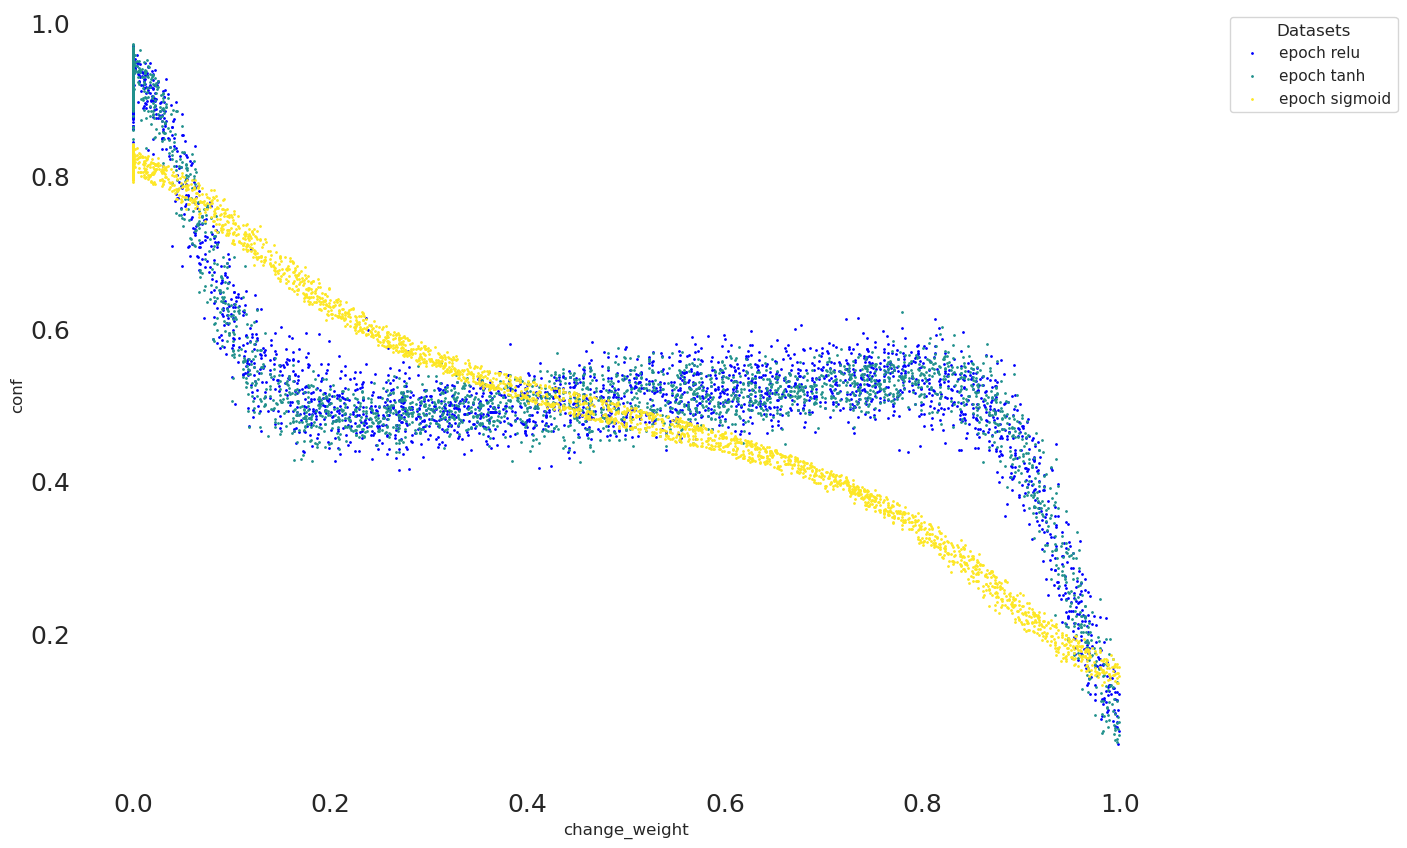

In [48]:
# Generate random datasets with the provided names
data_names = ['relu','tanh','sigmoid']
datasets = activation_datas
# plt.style.use('default')
# Create a scatter plot for each dataset using a different shade of blue
num_datasets = len(data_names)

plt.figure(figsize=(14, 10))
cmap = plt.cm.Blues
colors = plt.cm.viridis(np.linspace(0, 1, num_datasets))
x = adata.obs['change_weight']
for i, data in enumerate(datasets):
    if i == 0:
        plt.scatter(x, data, color="blue", label=f'epoch {data_names[i]}',s=1)
    else:
        plt.scatter(x, data, color=colors[i], label=f'epoch {data_names[i]}',s=1)

# Add titles, labels, and legend
# plt.title('Scatter Plot of Multiple Datasets with Blue Color Scale')
plt.xlabel('change_weight')
plt.ylabel('conf')
plt.legend(title='Datasets', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [49]:
# Generate random datasets with the provided names
data_names = ['relu','tanh','sigmoid']
datasets = activation_datas
# plt.style.use('default')
# Create a scatter plot for each dataset using a different shade of blue
num_datasets = len(data_names)
cor_list_activation

[-0.8559598350726884, -0.8470759714422194, -0.9258155973412638]

In [50]:
adata.X

array([[  7.16833481,   0.50087906,   0.26217391, ...,  -3.40813304,
          6.92610873,   5.23602081],
       [  1.80565512, -11.16314214,  -0.86418447, ...,  -1.30671317,
          2.98488061,   0.05738249],
       [  1.11887368,   5.74016752,   0.01471057, ...,   8.69962393,
         -3.22406503,   2.61085782],
       ...,
       [  5.78753372,   0.76825254,   1.769758  , ...,  -4.97888598,
          5.33574323,   5.35818097],
       [  2.13377666,   1.85897647,   4.25470301, ...,   1.336704  ,
          8.39988695,  -0.25000707],
       [  0.54590883,  -2.70631452,   0.96368662, ...,   3.22092378,
         -0.66725642,   1.67706672]])